#Initialization

In [3]:
 DEVICE = "cpu"

In [4]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from typing import Tuple
from torch.distributions.continuous_bernoulli import ContinuousBernoulli

torch.manual_seed(1012)




In [6]:
mnist = fetch_openml('mnist_784', as_frame=False, cache=False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [7]:
class DatasetWrapper(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [8]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train=X_train/255
X_test= X_test/255


train_ds = DatasetWrapper(X_train,y_train)
test_ds = DatasetWrapper(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=True)

#VAE

In [40]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from typing import Tuple

torch.manual_seed(1005)


## using the provided resource as base architecture
class VAE(nn.Module):
    def __init__(self, hidden_dims, data_dim=784, device=DEVICE):
        super().__init__()
        assert len(hidden_dims) == 5, "Insufficiently number of dimensions!"
        self.data_dim = data_dim
        self.device = device
        # define IO
        self.in_layer = nn.Linear(data_dim, hidden_dims[0])
        self.out_layer = nn.Linear(hidden_dims[-1], data_dim)
        # hidden layer
        self.enc_h = nn.Linear(hidden_dims[0], hidden_dims[1])
        # define hidden and latent
        self.enc_mu = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.enc_sigma = nn.Linear(hidden_dims[1], hidden_dims[2])
        # hidden layer decoder
        self.dec_h = nn.Linear(hidden_dims[2], hidden_dims[-2])
        self.dec_layer = nn.Linear(hidden_dims[-2], hidden_dims[-1])
        self.to(device)

    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h1 = F.relu(self.in_layer(x))
        h2 = F.relu(self.enc_h(h1))
        return self.enc_mu(h2), self.enc_sigma(h2)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        h3 = F.relu(self.dec_h(z))
        h4 = F.relu(self.dec_layer(h3))
        return torch.sigmoid(self.out_layer(h4))

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(x.view(-1, self.data_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [41]:
def train(model: VAE, epoch: int, train_loader: torch.utils.data.DataLoader, log_interval: int=25) -> list:
    model.train()
    train_loss = 0.
    train_loss_vals = []
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(model.device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(x)
        loss_val, ce, kld = loss(recon_batch, x, mu, logvar)
        loss_val.backward()
        train_loss += loss_val.item()
        train_loss_vals.append(loss_val.item())
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f"Train epoch={epoch} [{batch_idx*len(x)}/{len(train_loader.dataset)}]\t loss={loss_val.item() / len(x)}")
            print(f"BCE={ce} KLD={kld}")
    print(f"===> epoch={epoch} avrg.loss={train_loss/len(train_loader.dataset)}")
    return train_loss_vals

In [42]:
def test(model: VAE, epoch: int, test_loader: torch.utils.data.DataLoader) -> list:
    model.eval()
    test_loss = 0.
    test_loss_vals = []
    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            x = x.to(model.device)
            recon_batch, mu, logvar = model(x)
            test_loss_val, ce, kld = loss(recon_batch, x, mu, logvar)
            test_loss += test_loss_val.item()
            test_loss_vals.append(test_loss_val.item())
            # if i == 0: # TODO: do we want to persist images here?
            #     n = min(data.size(0), 8)
            #     comparison = torch.cat([x[:n], ])
    test_loss /= len(test_loader.dataset)
    print(f"===> Test loss={test_loss}")
    return test_loss_vals

In [43]:
EPOCHS=10

# 3.) modify the network architecture and try to obtain a better embedding
model_bern = VAE(hidden_dims=[300, 50, 2, 50, 300]) # NOTE: 2D latent space
optimizer = optim.Adam(model_bern.parameters(), lr=1e-3)


def loss(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    KLD = -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD # = -ELBO


train_loss_vals_total = []
test_loss_vals_total = []
for e in range(1, EPOCHS+1):
    train_loss_vals = train(model_bern, epoch=e, train_loader=train_loader)
    test_loss_vals = test(model_bern, epoch=e, test_loader=test_loader)
    train_loss_vals_total.append(train_loss_vals)
    test_loss_vals_total.append(test_loss_vals)

Train epoch=1 [0/52500]	 loss=544.4781494140625
BCE=69691.78125 KLD=1.4251465797424316
Train epoch=1 [3200/52500]	 loss=234.5133056640625
BCE=29116.505859375 KLD=901.1973876953125
Train epoch=1 [6400/52500]	 loss=206.3863983154297
BCE=25967.796875 KLD=449.6627197265625
Train epoch=1 [9600/52500]	 loss=204.26571655273438
BCE=25853.6328125 KLD=292.3780517578125
Train epoch=1 [12800/52500]	 loss=204.4307403564453
BCE=25883.625 KLD=283.51019287109375
Train epoch=1 [16000/52500]	 loss=190.8812255859375
BCE=24099.044921875 KLD=333.75146484375
Train epoch=1 [19200/52500]	 loss=189.7847442626953
BCE=23990.7265625 KLD=301.72149658203125
Train epoch=1 [22400/52500]	 loss=184.28182983398438
BCE=23228.43359375 KLD=359.6397705078125
Train epoch=1 [25600/52500]	 loss=190.8819122314453
BCE=23985.1484375 KLD=447.7359619140625
Train epoch=1 [28800/52500]	 loss=178.14682006835938
BCE=22271.912109375 KLD=530.880126953125
Train epoch=1 [32000/52500]	 loss=174.76698303222656
BCE=21821.0703125 KLD=549.10345

##Quantify

In [44]:
model_bern.eval()
recon_x,mu, logvar = model_bern(torch.tensor(X_test))
print(F.mse_loss(torch.logit(torch.tensor(X_test),1e-6),torch.logit(recon_x,1e-6)))
print(F.mse_loss(torch.tensor(X_test),recon_x))

tensor(43.0872, grad_fn=<MseLossBackward0>)
tensor(0.0409, grad_fn=<MseLossBackward0>)


## Pictures to evaluate

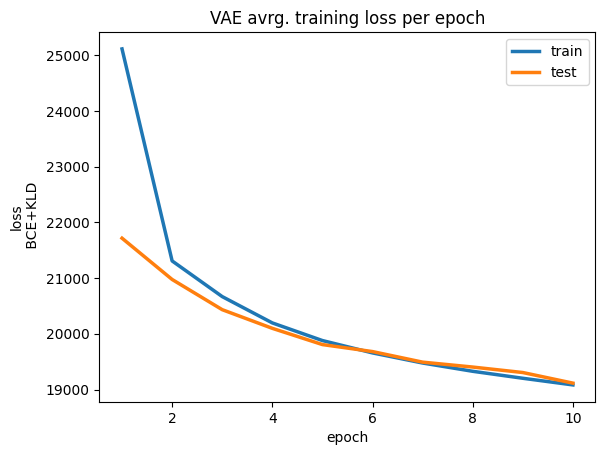

In [46]:
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in train_loss_vals_total], lw=2.5, label="train")
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in test_loss_vals_total], lw=2.5, label="test")
plt.xlabel("epoch")
plt.ylabel("loss\n BCE+KLD")
# plt.yscale("log")
plt.title("VAE avrg. training loss per epoch")
plt.legend()
plt.show()

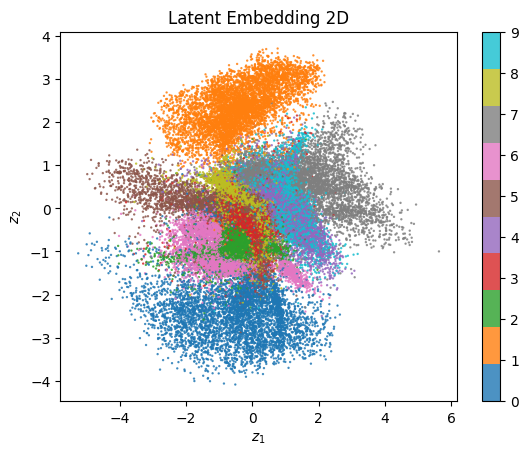

In [45]:
latent_coordinates = []
for data in X_train:
    # NOTE: we only obtain the mean for encoding and discard the log var
    latent_coordinates.append(model_bern.encode(torch.Tensor(data).to(DEVICE))[0].cpu().detach().numpy())
latent_coordinates = np.array(latent_coordinates)

plt.scatter(latent_coordinates[:,0], latent_coordinates[:,1], alpha=.8, s=0.5, c=y_train, cmap="tab10")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
plt.colorbar()
plt.title("Latent Embedding 2D")
plt.show()

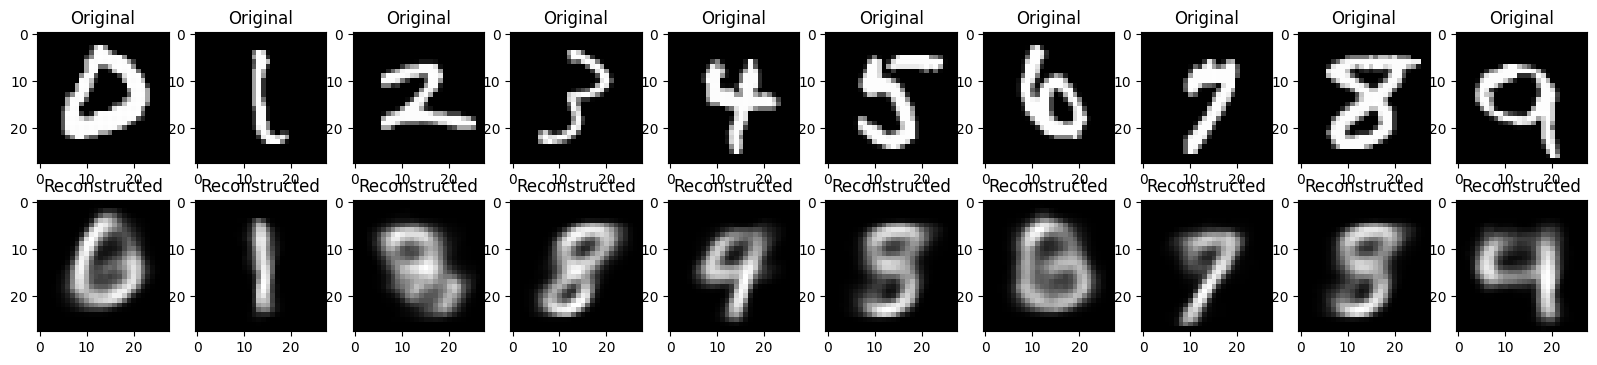

In [48]:
# Visualize some reconstructed images
no_images=[5,17,7,10,1,15,6,4,0,12]
plt.figure(figsize=(20, 4))
for i , j in enumerate(no_images):
    # Original Images
    reconstructed_images,_,_= model_bern(torch.tensor([X_test])[:,j])
    plt.subplot(2, 10, i + 1)
    plt.imshow(X_test[j].reshape(28, 28), cmap='gray')
    plt.title('Original')

    # Reconstructed Images
    plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(reconstructed_images.detach().numpy().reshape(28, 28), cmap='gray')
    plt.title('Reconstructed')

plt.show()

# Cont Bernoulli VAE

In [12]:
def cont_bern_log_norm(lam, l_lim=0.4, u_lim=0.56):
    # computes the log normalizing constant of a continuous Bernoulli distribution in a numerically stable way.
    # returns the log normalizing constant for lam in (0, l_lim) U (u_lim, 1) and a Taylor approximation in
    # [l_lim, u_lim].
    # cut_lam below might appear useless, but it is important to not evaluate log_norm near 0.5 as torch.where evaluates
    # both options, regardless of the value of the condition.
    cut_lam = torch.where(torch.logical_or(torch.less(lam, l_lim), torch.greater(lam, u_lim)), lam, l_lim * torch.ones_like(lam))
    log_norm = torch.log(torch.abs(2.0 * torch.atanh(1 - 2.0 * cut_lam))) - torch.log(torch.abs(1 - 2.0 * cut_lam))
    taylor = torch.log(torch.tensor(2.0)) + 4.0 / 3.0 * torch.pow(lam - 0.5, 2) + 104.0 / 45.0 * torch.pow(lam - 0.5, 4)
    return torch.where(torch.logical_or(torch.less(lam, l_lim), torch.greater(lam, u_lim)), log_norm, taylor)

In [8]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from typing import Tuple

torch.manual_seed(1005)


## using the provided resource as base architecture
class cont_VAE(nn.Module):
    def __init__(self, hidden_dims, data_dim=784, device=DEVICE):
        super().__init__()
        assert len(hidden_dims) == 5, "Insufficiently number of dimensions!"
        self.data_dim = data_dim
        self.device = device
        # define IO
        self.in_layer = nn.Linear(data_dim, hidden_dims[0])
        self.out_layer = nn.Linear(hidden_dims[-1], data_dim)
        # hidden layer
        self.enc_h = nn.Linear(hidden_dims[0], hidden_dims[1])
        # define hidden and latent
        self.enc_mu = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.enc_sigma = nn.Linear(hidden_dims[1], hidden_dims[2])
        # hidden layer decoder
        self.dec_h = nn.Linear(hidden_dims[2], hidden_dims[-2])
        self.dec_layer = nn.Linear(hidden_dims[-2], hidden_dims[-1])
        self.to(device)

    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h1 = F.relu(self.in_layer(x))
        h2 = F.relu(self.enc_h(h1))
        return self.enc_mu(h2), self.enc_sigma(h2)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        h3 = F.relu(self.dec_h(z))
        h4 = F.relu(self.dec_layer(h3))
        return torch.sigmoid(self.out_layer(h4))

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(x.view(-1, self.data_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [9]:
def train_cont(model: cont_VAE, epoch: int, train_loader: torch.utils.data.DataLoader, log_interval: int=25) -> list:
    model.train()
    train_loss = 0.
    train_loss_vals = []
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(model.device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(x)
        loss_val, ce, kld = loss_cont(recon_batch, x, mu, logvar)
        loss_val.backward()
        train_loss += loss_val.item()
        train_loss_vals.append(loss_val.item())
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f"Train epoch={epoch} [{batch_idx*len(x)}/{len(train_loader.dataset)}]\t loss={loss_val.item() / len(x)}")
            print(f"BCE={ce} KLD={kld}")
    print(f"===> epoch={epoch} avrg.loss={train_loss/len(train_loader.dataset)}")
    return train_loss_vals

def test_cont(model: cont_VAE, epoch: int, test_loader: torch.utils.data.DataLoader) -> list:
    model.eval()
    test_loss = 0.
    test_loss_vals = []
    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            x = x.to(model.device)
            recon_batch, mu, logvar = model(x)
            test_loss_val, ce, kld = loss_cont(recon_batch, x, mu, logvar)
            test_loss += test_loss_val.item()
            test_loss_vals.append(test_loss_val.item())
            # if i == 0: # TODO: do we want to persist images here?
            #     n = min(data.size(0), 8)
            #     comparison = torch.cat([x[:n], ])
    test_loss /= len(test_loader.dataset)
    print(f"===> Test loss={test_loss}")
    return test_loss_vals

In [14]:
EPOCHS=15

# 3.) modify the network architecture and try to obtain a better embedding
model_cont = cont_VAE(hidden_dims=[300, 50, 2, 50, 300]) # NOTE: 2D latent space
optimizer = optim.Adam(model_cont.parameters(), lr=0.001)

def loss_cont(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"
    recon_x = torch.where(recon_x <=0.0001,0.00001,recon_x)
    recon_x = torch.where(recon_x >=0.9999,0.99999,recon_x)
    assert torch.min(recon_x) >= 0 and torch.max(recon_x) <= 1, "Invalid values in recon_x"
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum") - torch.sum(cont_bern_log_norm(recon_x))
    KLD = -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD,  BCE , KLD # = -ELBO

train_loss_vals_total = []
test_loss_vals_total = []
for e in range(1, EPOCHS+1):
    train_loss_vals = train_cont(model_cont, epoch=e, train_loader=train_loader)
    test_loss_vals = test_cont(model_cont, epoch=e, test_loader=test_loader)
    train_loss_vals_total.append(train_loss_vals)
    test_loss_vals_total.append(test_loss_vals)

Train epoch=1 [0/52500]	 loss=0.0463101789355278
BCE=4.859375 KLD=1.0683279037475586
Train epoch=1 [3200/52500]	 loss=-1031.8143310546875
BCE=-135849.8125 KLD=3777.576416015625
Train epoch=1 [6400/52500]	 loss=-1215.502685546875
BCE=-156693.71875 KLD=1109.3765869140625
Train epoch=1 [9600/52500]	 loss=-1173.1033935546875
BCE=-150935.03125 KLD=777.8043212890625
Train epoch=1 [12800/52500]	 loss=-1216.3245849609375
BCE=-156425.953125 KLD=736.3992919921875
Train epoch=1 [16000/52500]	 loss=-1260.1534423828125
BCE=-162234.15625 KLD=934.5169067382812
Train epoch=1 [19200/52500]	 loss=-1236.3209228515625
BCE=-158875.78125 KLD=626.7053833007812
Train epoch=1 [22400/52500]	 loss=-1252.8023681640625
BCE=-160905.296875 KLD=546.5886840820312
Train epoch=1 [25600/52500]	 loss=-1228.0025634765625
BCE=-157735.375 KLD=551.05029296875
Train epoch=1 [28800/52500]	 loss=-1275.008056640625
BCE=-163827.5625 KLD=626.524169921875
Train epoch=1 [32000/52500]	 loss=-1261.8759765625
BCE=-162285.625 KLD=765.502

## Quantify

In [11]:
model_cont.eval()
recon_x, mu, logvar = model_cont(torch.tensor(X_test))
print(F.mse_loss(torch.logit(torch.tensor(X_test),1e-5),torch.logit(recon_x,1e-5)))
print(F.mse_loss(torch.logit(torch.tensor(X_test),1e-5),torch.logit(recon_x,1e-5)))

tensor(13.5247, grad_fn=<MseLossBackward0>)


## Pictures

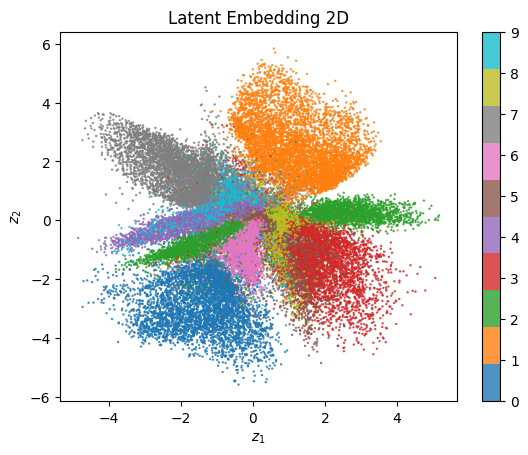

In [12]:
latent_coordinates = []
for data in X_train:
    # NOTE: we only obtain the mean for encoding and discard the log var
    latent_coordinates.append(model_cont.encode(torch.Tensor(data).to(DEVICE))[0].cpu().detach().numpy())
latent_coordinates = np.array(latent_coordinates)

plt.scatter(latent_coordinates[:,0], latent_coordinates[:,1], alpha=.8, s=0.5, c=y_train, cmap="tab10")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
plt.colorbar()
plt.title("Latent Embedding 2D")
plt.show()

<ipython-input-13-ead10b3bced6>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  reconstructed_image,_,_= model_cont(torch.tensor([X_test])[:,j])


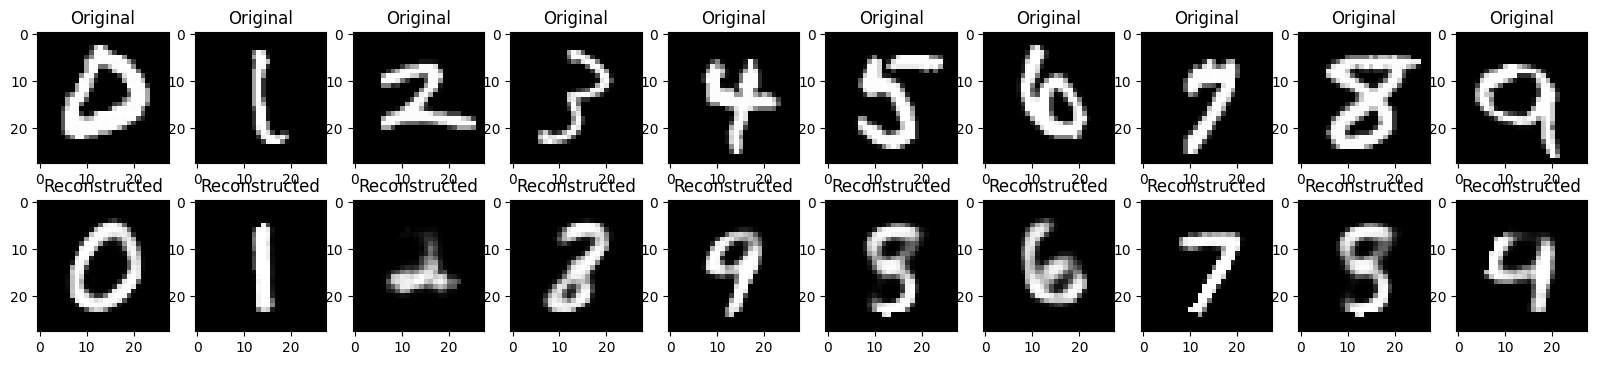

In [13]:
no_images=[5,17,7,10,1,15,6,4,0,12]
plt.figure(figsize=(20, 4))
for i , j in enumerate(no_images):
    # Original Images
    reconstructed_image,_,_= model_cont(torch.tensor([X_test])[:,j])
    plt.subplot(2, 10, i + 1)
    plt.imshow(X_test[j].reshape(28, 28), cmap='gray')
    plt.title('Original')

    # Reconstructed Images
    plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(reconstructed_image.detach().numpy().reshape(28, 28), cmap='gray')
    plt.title('Reconstructed')

plt.show()

#Beta VAE

In [49]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.nn import functional as F
from torch.distributions.beta import Beta
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from typing import Tuple

torch.manual_seed(1005)


## using the provided resource as base architecture
class Beta_VAE(nn.Module):
    def __init__(self, hidden_dims, data_dim=784, device=DEVICE):
        super().__init__()
        assert len(hidden_dims) == 5, "Insufficiently number of dimensions!"
        self.data_dim = data_dim
        self.device = device
        # define IO
        self.in_layer = nn.Linear(data_dim, hidden_dims[0])
        nn.init.xavier_uniform_(self.in_layer.weight)
        nn.init.zeros_(self.in_layer.bias)
        self.out_layer = nn.Linear(hidden_dims[-1], data_dim*2)#data_dim*2#nn.Sequential(nn.Linear(hidden_dims[-1], data_dim*2),nn.ReLU(),nn.Linear(data_dim*2, data_dim*2))
        #changed data_dim to data_dim*2
        # hidden layer
        self.enc_h = nn.Linear(hidden_dims[0], hidden_dims[1])
        # define hidden and latent
        self.enc_mu = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.enc_sigma = nn.Linear(hidden_dims[1], hidden_dims[2])
        # hidden layer decoder
        self.dec_h = nn.Linear(hidden_dims[2], hidden_dims[-2])
        self.dec_layer = nn.Linear(hidden_dims[-2], hidden_dims[-1])
        self.to(device)
        nn.init.kaiming_normal_(self.in_layer.weight)
        nn.init.kaiming_normal_(self.enc_h.weight)
        nn.init.kaiming_normal_(self.enc_mu.weight)
        nn.init.kaiming_normal_(self.enc_sigma.weight)
        nn.init.kaiming_normal_(self.dec_h.weight)
        nn.init.kaiming_normal_(self.dec_layer.weight)



    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        #print("x",x.shape,"\n",x[0:1,0])
        h1 = F.relu(self.in_layer(x))
        #print("weights", self.in_layer.weight[12:14,  12:14])
        #print("in layer",self.in_layer(x).shape,"\n",self.in_layer(x)[0:1,0])
        #print("h1",h1[0:1,0:1])
        h2 = F.relu(self.enc_h(h1))
        #print("h2", h2[0,0])
        return self.enc_mu(h2), self.enc_sigma(h2)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        h3 = F.relu(self.dec_h(z))
        h4 = F.relu(self.dec_layer(h3))
        out = self.out_layer(h4).view(-1,784,2)
        return F.softplus(out)  # Apply sigmoid activation

    def reconstruct_x(self, alfaBeta: torch.Tensor):
        alfa=alfaBeta[:,:,0]#*15
        beta=alfaBeta[:,:,1]#*10
        #tmp1=torch.where(torch.logical_and(beta>1,alfa>1),(alfa-1)/(alfa+beta-2),0)
        #tmp2=torch.where(torch.logical_and(beta<1,alfa<1),1,0)
        #recon_x=tmp1+tmp2 # recon_x is mode
        recon_x=alfa/(alfa+beta) #recon_x is mean
        return(recon_x)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(x.view(-1, self.data_dim))
        z = self.reparameterize(mu, logvar)
        alfabeta=self.decode(z)
        #print("\n Forward\n x:", x[0:2,0:2],"mu:", mu[0:2], "logvar:", logvar[0:2],"\n z:", z[0:2], "decode(z)", self.decode(z).shape, "\n \n")
        return self.reconstruct_x(alfabeta),alfabeta,  mu, logvar

In [50]:
def train_beta(model: Beta_VAE, epoch: int, train_loader: torch.utils.data.DataLoader, log_interval: int=25) -> list:
    model.train()
    train_loss = 0.
    train_loss_vals = []
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(model.device)
        #print("x", torch.max(x),torch.min(x))
        optimizer.zero_grad()
        recon_batch,alfabeta, mu, logvar = model(x)
        loss_val, ce, kld = loss_beta(alfabeta, x, mu, logvar)
        #print("loss_val", loss_val)
        loss_val.backward()
        train_loss += loss_val.item()
        train_loss_vals.append(loss_val.item())
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f"Train epoch={epoch} [{batch_idx*len(x)}/{len(train_loader.dataset)}]\t loss={loss_val.item() / len(x)}")
            print(f"loss={ce} KLD={kld}")
    print(f"===> epoch={epoch} avrg.loss={train_loss/len(train_loader.dataset)}")
    return train_loss_vals

In [51]:
def test_beta(model: Beta_VAE, epoch: int, test_loader: torch.utils.data.DataLoader) -> list:
    model.eval()
    test_loss = 0.
    test_loss_vals = []
    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            x = x.to(model.device)
            recon_batch,alfabeta, mu, logvar = model(x)
            test_loss_val, ce, kld = loss_beta(alfabeta, x, mu, logvar)
            test_loss += test_loss_val.item()
            test_loss_vals.append(test_loss_val.item())
            # if i == 0: # TODO: do we want to persist images here?
            #     n = min(data.size(0), 8)
            #     comparison = torch.cat([x[:n], ])
    test_loss /= len(test_loader.dataset)
    print(f"===> Test loss={test_loss}")
    return test_loss_vals

In [52]:
EPOCHS=10

# 3.) modify the network architecture and try to obtain a better embedding
model_beta = Beta_VAE(hidden_dims=[300, 50, 2, 50, 300]) # NOTE: 2D latent space
optimizer = optim.Adam(model_beta.parameters(), lr=1e-3)
#torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)


def loss_beta(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    #assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"
    #print("recon_x",recon_x[0:5,0:5,:])
    x = torch.where(x <=0.0001,0.00001,x)
    x = torch.where(x >=0.9999,0.99999,x)
    #recon_x[:,:,0] = torch.where(recon_x[:,:,0] <=1.,1.,recon_x[:,:,0])
    #print(recon_x.shape)
    assert torch.min(x) >= 0 and torch.max(x) <= 1, "Invalid values in x"
    Beta_dist=Beta(recon_x[:,:,0],recon_x[:,:,1])
    #print("\n\nrecon_x", torch.max(recon_x), torch.min(recon_x))
    #print("x", torch.max(x), torch.min(x))
    #print("beta",torch.min((Beta_dist.log_prob(x))),torch.max((Beta_dist.log_prob(x))),torch.mean(Beta_dist.log_prob(x)))
    #mode=(recon_x[:,:,0]-1)/(recon_x[:,:,0]+recon_x[:,:,1]+2)
    #print("addition:",torch.max(mode),torch.min(mode),torch.mean(mode))
    loss=torch.sum(-(Beta_dist.log_prob(x)))#-torch.max(Beta_dist.log_prob(ad))))
    KLD = -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    #print("loss:", loss, "KLD:",KLD)
    return loss + KLD,  loss , KLD # = -ELBO


train_loss_vals_total = []
test_loss_vals_total = []
for e in range(1, EPOCHS+1):
    train_loss_vals = train_beta(model_beta, epoch=e, train_loader=train_loader)
    test_loss_vals = test_beta(model_beta, epoch=e, test_loader=test_loader)
    train_loss_vals_total.append(train_loss_vals)
    test_loss_vals_total.append(test_loss_vals)

Train epoch=1 [0/52500]	 loss=-1431.1375732421875
loss=-183237.90625 KLD=52.30307388305664
Train epoch=1 [3200/52500]	 loss=-4988.57373046875
loss=-639253.75 KLD=716.2916259765625
Train epoch=1 [6400/52500]	 loss=-5062.25732421875
loss=-648685.25 KLD=716.3117065429688
Train epoch=1 [9600/52500]	 loss=-5079.77880859375
loss=-651010.625 KLD=798.95361328125
Train epoch=1 [12800/52500]	 loss=-5117.90869140625
loss=-655930.0 KLD=837.665771484375
Train epoch=1 [16000/52500]	 loss=-5146.72509765625
loss=-659756.125 KLD=975.297119140625
Train epoch=1 [19200/52500]	 loss=-5125.45263671875
loss=-657245.4375 KLD=1187.4886474609375
Train epoch=1 [22400/52500]	 loss=-5156.63720703125
loss=-661459.4375 KLD=1409.9010009765625
Train epoch=1 [25600/52500]	 loss=-5191.26220703125
loss=-666059.0625 KLD=1577.49951171875
Train epoch=1 [28800/52500]	 loss=-5205.521484375
loss=-668022.375 KLD=1715.59716796875
Train epoch=1 [32000/52500]	 loss=-5163.7353515625
loss=-662653.6875 KLD=1695.59228515625
Train epoc

## Picture to evaluate model

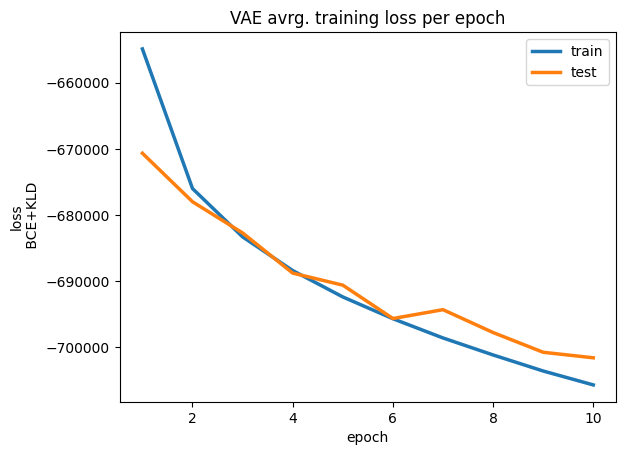

In [53]:
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in train_loss_vals_total], lw=2.5, label="train")
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in test_loss_vals_total], lw=2.5, label="test")
plt.xlabel("epoch")
plt.ylabel("loss\n BCE+KLD")
# plt.yscale("log")
plt.title("VAE avrg. training loss per epoch")
plt.legend()
plt.show()

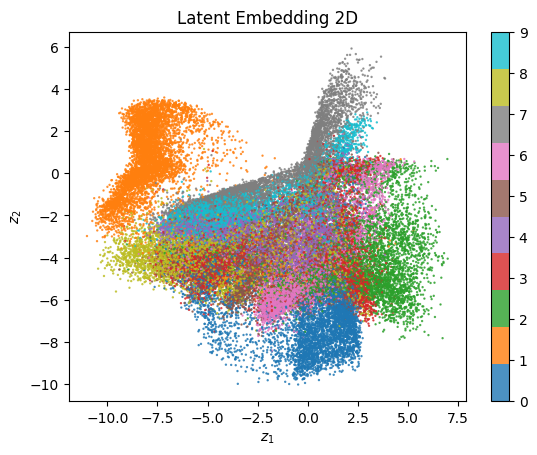

In [54]:
latent_coordinates = []
for data in X_train:
    # NOTE: we only obtain the mean for encoding and discard the log var
    latent_coordinates.append(model_beta.encode(torch.Tensor(data).to(DEVICE))[0].cpu().detach().numpy())
latent_coordinates = np.array(latent_coordinates)

plt.scatter(latent_coordinates[:,0], latent_coordinates[:,1], alpha=.8, s=0.5, c=y_train, cmap="tab10")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
plt.colorbar()
plt.title("Latent Embedding 2D")
plt.show()

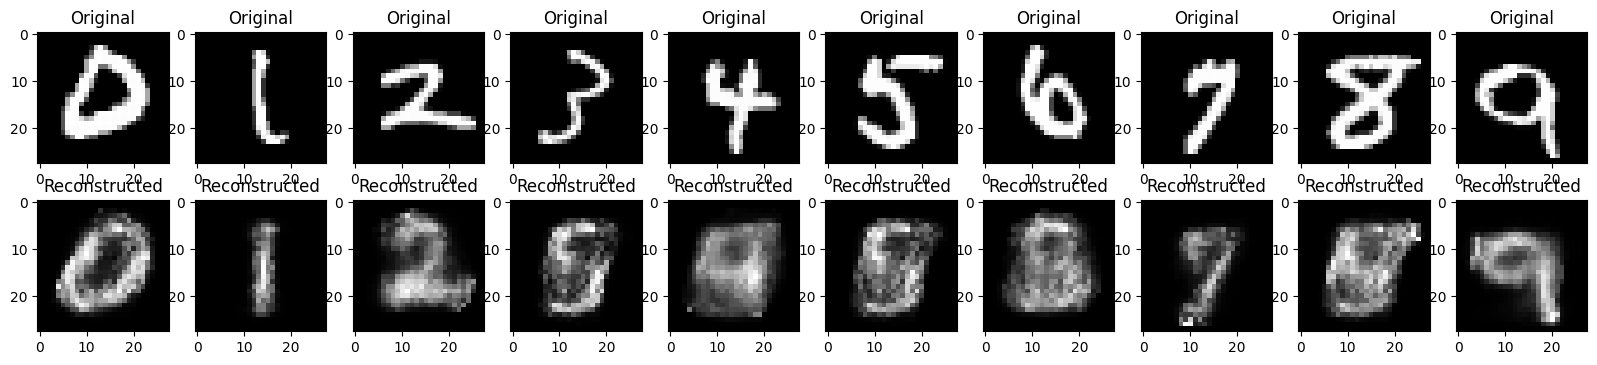

In [55]:
# Visualize some reconstructed images
no_images=[5,17,7,10,1,15,6,4,0,12]
plt.figure(figsize=(20, 4))
for i , j in enumerate(no_images):
    # Original Images
    reconstructed_image,_,_,_= model_beta(torch.tensor([X_test])[:,j])
    plt.subplot(2, 10, i + 1)
    plt.imshow(X_test[j].reshape(28, 28), cmap='gray')
    plt.title('Original')

    # Reconstructed Images
    plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(reconstructed_image.detach().numpy().reshape(28, 28), cmap='gray')
    plt.title('Reconstructed')

plt.show()

##Quantify

In [56]:
model_beta.eval()
recon_x,alfabeta, mu, logvar = model_beta(torch.tensor(X_test))
print(F.mse_loss(torch.logit(torch.tensor(X_test),1e-6),torch.logit(recon_x,1e-6),reduction="mean"))
print(F.mse_loss(torch.tensor(X_test),recon_x))

tensor(58.0021, grad_fn=<MseLossBackward0>)
tensor(0.0568, grad_fn=<MseLossBackward0>)


#Ladder VAE

In [57]:
!pip install torchvision
import torchvision

In [58]:
import torch.nn.functional as F
from typing import Tuple

class Ladder_VAE3(nn.Module):
    def __init__(self, hidden_dims, data_dim=784, device=DEVICE):
        super(Ladder_VAE3,self).__init__()
        assert len(hidden_dims) == 11, "Insufficient number of dimensions!"
        self.data_dim = data_dim
        self.device = device
        # define IO
        self.in_layer = nn.Linear(data_dim, hidden_dims[0])
        self.out_layer = nn.Linear(hidden_dims[-1], data_dim)
        # Encoder layers for z1
        self.enc_h1 = (torchvision.ops.MLP(in_channels=hidden_dims[0], hidden_channels= [hidden_dims[1],hidden_dims[2]] ))
        self.enc_mu1 = nn.Linear(hidden_dims[2], hidden_dims[3])
        self.enc_sigma1 = nn.Sequential(
            nn.Linear(hidden_dims[2], hidden_dims[3]),
            nn.Softplus())

        # Encoder layers for z2
        self.enc_h2 = (torchvision.ops.MLP(in_channels=hidden_dims[3], hidden_channels= [hidden_dims[4],hidden_dims[5]]))
        self.enc_mu2 = nn.Linear(hidden_dims[5], hidden_dims[6])
        self.enc_sigma2 = nn.Sequential(
            nn.Linear(hidden_dims[5], hidden_dims[6]),
            nn.Softplus())

        # Encoder layers for z3
        self.enc_h3 = (torchvision.ops.MLP(in_channels=hidden_dims[6], hidden_channels= [hidden_dims[7],hidden_dims[8]]))
        self.enc_mu3 = nn.Linear(hidden_dims[8], hidden_dims[9])
        self.enc_sigma3 = nn.Sequential(
            nn.Linear(hidden_dims[8], hidden_dims[9]),
            nn.Softplus())
        # Decoder layers for z3
        self.dec_h3 = nn.Linear(hidden_dims[3], hidden_dims[10])
        self.dec_layer = nn.Linear(hidden_dims[10], hidden_dims[-1])

        #Decoder from z3 to z3
        self.dec_z3_to_z2 = torchvision.ops.MLP(in_channels=hidden_dims[9], hidden_channels= [hidden_dims[7],hidden_dims[6]])
        self.dec_z2_to_z1 = torchvision.ops.MLP(in_channels=hidden_dims[6], hidden_channels= [hidden_dims[4],hidden_dims[3]])
        self.to(device)


    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        h0 = F.relu(self.in_layer(x))
        h1 = F.relu(self.enc_h1(h0))
        #print("h1",h1.shape)
        h2 = F.relu(self.enc_h2(h1))
        #print("h2",h2.shape)

        h3 = F.relu(self.enc_h3(h2))
        #print("h3",h3.shape)
        mu3 = self.enc_mu3(h3)
        logvar3 = self.enc_sigma3(h3)
        z3 = self.reparameterize(mu3, logvar3)
        #print("z3", z3.shape)
        tmp2=F.relu(self.dec_z3_to_z2(z3)+h2)
        #print("tmp2", tmp2.shape)

        #print("z1", z1.shape,"z2", z2.shape,"z3", z3.shape)
        mu2 = self.enc_mu2(tmp2)
        logvar2 = self.enc_sigma2(tmp2)
        z2 = self.reparameterize(mu2, logvar2)
        tmp1=F.relu(self.dec_z2_to_z1(z2)+h1)
        #print("tmp1", tmp1.shape)
        mu1 = self.enc_mu1(tmp1)
        logvar1 = self.enc_sigma1(tmp1)
        z1 = self.reparameterize(mu1, logvar1)
        return z1, z2, z3, mu1, logvar1, mu2, logvar2, mu3, logvar3

    def decode(self, z3: torch.Tensor,z2: torch.Tensor,z1: torch.Tensor) -> torch.Tensor:
        z2_prime = F.relu(self.dec_z3_to_z2(z3)+z2)
        z1_prime =F.relu(self.dec_z2_to_z1(z2_prime)+z1)
        h4 = F.relu(self.dec_h3(z1_prime))
        h5 = F.relu(self.dec_layer(h4))
        return torch.sigmoid(self.out_layer(h5))

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        z1, z2, z3, mu1, logvar1, mu2, logvar2, mu3, logvar3 = self.encode(x.view(-1, self.data_dim))
        #print("z1", z1.shape,"z2", z2.shape,"z3", z3.shape)

        return self.decode(z3,z2,z1), mu1, logvar1, mu2, logvar2, mu3, logvar3


In [59]:
def test_ladder(model: Ladder_VAE3, epoch: int, test_loader: torch.utils.data.DataLoader) -> list:
    model.eval()
    test_loss = 0.
    test_loss_vals = []
    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            x = x.to(model.device)
            recon_batch, mu1, logvar1, mu2, logvar2, mu3, logvar3 = model_ladder(x)
            test_loss_val, _, _ = loss_ladder(x,recon_batch, mu1, logvar1, mu2, logvar2, mu3, logvar3)
            test_loss += test_loss_val.item()
            test_loss_vals.append(test_loss_val.item())
    test_loss /= len(test_loader.dataset)
    print(f"===> Test loss={test_loss}")
    return test_loss_vals


def train_ladder(model: Ladder_VAE3, epoch: int, train_loader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer, log_interval: int=25) -> list:
    model.train()
    train_loss = 0.
    train_loss_vals = []
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(model.device)
        optimizer.zero_grad()
        recon_batch, mu1, logvar1, mu2, logvar2, mu3, logvar3 = model_ladder(x)
        #print("recon_batch",recon_batch.shape)
        #print("mu1", mu1.shape,"logvar1", logvar1.shape)
        #print("mu2", mu2.shape,"logvar2", logvar2.shape)
        #print("mu3", mu3.shape,"logvar3", logvar3.shape)
        loss_val, ce, kld = loss_ladder(x,recon_batch, mu1, logvar1, mu2, logvar2, mu3, logvar3)
        loss_val.backward()
        train_loss += loss_val.item()
        train_loss_vals.append(loss_val.item())
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f"Train epoch={epoch} [{batch_idx*len(x)}/{len(train_loader.dataset)}]\t loss={loss_val.item() / len(x)}")
    print(f"===> epoch={epoch} avrg.loss={train_loss/len(train_loader.dataset)}")
    return train_loss_vals

In [60]:
EPOCHS=10

# Assuming you have defined your train_loader and test_loader
# Modify as needed
def loss_ladder(x, recon_x, mu1, logvar1, mu2, logvar2, mu3, logvar3) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"

    x = torch.where(x <=0.0001,0.00001,x)
    x = torch.where(x >=0.9999,0.99999,x)
    recon_x = torch.where(recon_x <=0.0001,0.00001,recon_x)
    recon_x = torch.where(recon_x >=0.9999,0.99999,recon_x)
    #print(cont_bern_log_norm(recon_x))
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum") - torch.sum(cont_bern_log_norm(recon_x))
    KLD = -1/2 * (torch.sum(1 + logvar1 - mu1.pow(2) - logvar1.exp())+torch.sum(1 + logvar2 - mu2.pow(2) - logvar2.exp())+torch.sum(1 + logvar3 - mu3.pow(2) - logvar3.exp()))
    return BCE + KLD, BCE, KLD # = -ELBO


model_ladder = Ladder_VAE3(hidden_dims=[300, 300,50,50,2,2,2,2,2, 2, 300])  # NOTE: 2D latent space
optimizer = optim.Adam(model_ladder.parameters(), lr=1e-3)

train_loss_vals_total = []
test_loss_vals_total = []
for e in range(1, EPOCHS+1):
    train_loss_vals = train_ladder(model_ladder, epoch=e, train_loader=train_loader, optimizer=optimizer)
    test_loss_vals = test_ladder(model_ladder, epoch=e, test_loader=test_loader)
    train_loss_vals_total.append(train_loss_vals)
    test_loss_vals_total.append(test_loss_vals)

Train epoch=1 [0/52500]	 loss=11.042513847351074
Train epoch=1 [3200/52500]	 loss=-1136.154296875
Train epoch=1 [6400/52500]	 loss=-1158.7872314453125
Train epoch=1 [9600/52500]	 loss=-1187.2685546875
Train epoch=1 [12800/52500]	 loss=-1193.98583984375
Train epoch=1 [16000/52500]	 loss=-1217.8050537109375
Train epoch=1 [19200/52500]	 loss=-1230.761962890625
Train epoch=1 [22400/52500]	 loss=-1209.596435546875
Train epoch=1 [25600/52500]	 loss=-1223.371337890625
Train epoch=1 [28800/52500]	 loss=-1228.419921875
Train epoch=1 [32000/52500]	 loss=-1253.4156494140625
Train epoch=1 [35200/52500]	 loss=-1208.2542724609375
Train epoch=1 [38400/52500]	 loss=-1269.15673828125
Train epoch=1 [41600/52500]	 loss=-1267.953857421875
Train epoch=1 [44800/52500]	 loss=-1269.1412353515625
Train epoch=1 [48000/52500]	 loss=-1260.8753662109375
Train epoch=1 [51200/52500]	 loss=-1268.2086181640625
===> epoch=1 avrg.loss=-1190.7112786690848
===> Test loss=-1270.8571205357143
Train epoch=2 [0/52500]	 loss=-

In [61]:
model_ladder.eval()
recon_x, mu1,logvar1, mu2, logvar2, mu3, logvar3 = model_ladder(torch.tensor(X_test))
print(F.mse_loss(torch.logit(torch.tensor(X_test),1e-6),torch.logit(recon_x,1e-6),reduction="mean"))

tensor(12.8823, grad_fn=<MseLossBackward0>)


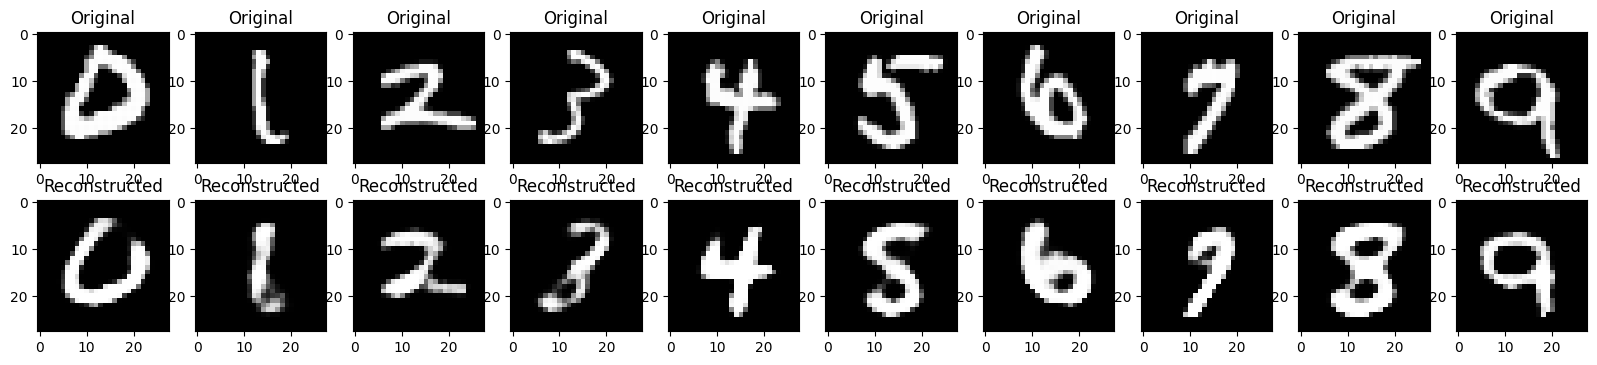

In [62]:
no_images=[5,17,7,10,1,15,6,4,0,12]
plt.figure(figsize=(20, 4))
for i , j in enumerate(no_images):
    # Original Images
    reconstructed_image, mu1, logvar1, mu2, logvar2, mu3, logvar3_= model_ladder(torch.tensor([X_test])[:,j])
    plt.subplot(2, 10, i + 1)
    plt.imshow(X_test[j].reshape(28, 28), cmap='gray')
    plt.title('Original')

    # Reconstructed Images
    plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(reconstructed_image.detach().numpy().reshape(28, 28), cmap='gray')
    plt.title('Reconstructed')

plt.show()

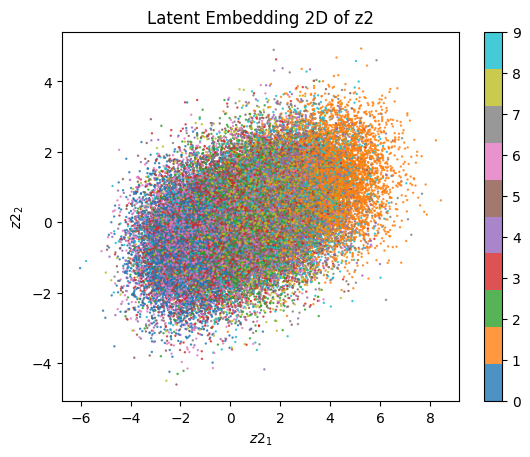

In [63]:
latent_coordinates = []
for data in X_train:
    # NOTE: we only obtain the mean for encoding and discard the log var=
    z1, z2, z3, mu1, logvar1, mu2, logvar2, mu3, logvar3=model_ladder.encode(torch.Tensor(data).to(DEVICE))
    #print(z1.shape,z2.shape, z3.shape)
    latent_coordinates.append(z2.cpu().detach().numpy())
latent_coordinates = np.array(latent_coordinates)

plt.scatter(latent_coordinates[:,0], latent_coordinates[:,1], alpha=.8, s=0.5, c=y_train, cmap="tab10")
plt.xlabel(r"$z2_1$")
plt.ylabel(r"$z2_2$")
plt.colorbar()
plt.title("Latent Embedding 2D of z2")
plt.show()

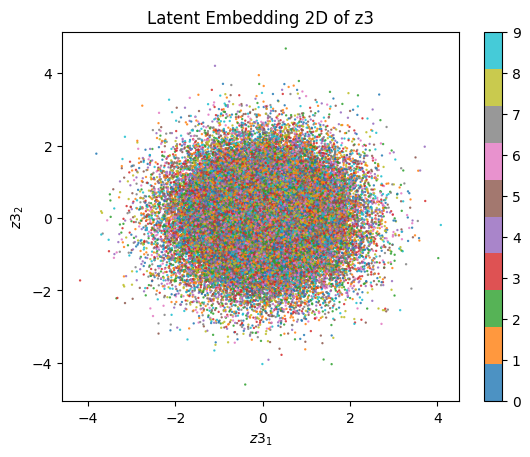

In [64]:
latent_coordinates = []
for data in X_train:
    # NOTE: we only obtain the mean for encoding and discard the log var=
    z1, z2, z3, mu1, logvar1, mu2, logvar2, mu3, logvar3=model_ladder.encode(torch.Tensor(data).to(DEVICE))
    #print(z1.shape,z2.shape, z3.shape)
    latent_coordinates.append(z3.cpu().detach().numpy())
latent_coordinates = np.array(latent_coordinates)

plt.scatter(latent_coordinates[:,0], latent_coordinates[:,1], alpha=.8, s=0.5, c=y_train, cmap="tab10")
plt.xlabel(r"$z3_1$")
plt.ylabel(r"$z3_2$")
plt.colorbar()
plt.title("Latent Embedding 2D of z3")
plt.show()